In [1]:
#basic
import pandas as pd
import numpy as np

#sci-kit learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#tensorflow
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Add, Dense, Dropout, Embedding,
                                     GlobalAveragePooling1D, Input, Layer,
                                     LayerNormalization, MultiHeadAttention)

#System
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Katherine's path
os.chdir('/content/drive/MyDrive/DSO569/DSO 569 Final Project and Presentation/Data')

# manhui's path
# os.chdir('/content/drive/MyDrive/DSO 569 Project and Presentation/Data')

# Wenyi's path
# os.chdir('/content/drive/MyDrive/DSO 569 Final Project and Presentation/Data')

## Data Preprocessing

In [3]:
# Load the dataset
label_df = pd.read_csv("./labels.csv")

In [4]:
# Train data shape
print(f"Train dataset length: {label_df.shape[0]}")
label_df.head()

Train dataset length: 10222


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


###EDA

<ipython-input-5-b2dbff3f8812>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(breed_classes, x='breed', y='count', palette="flare")


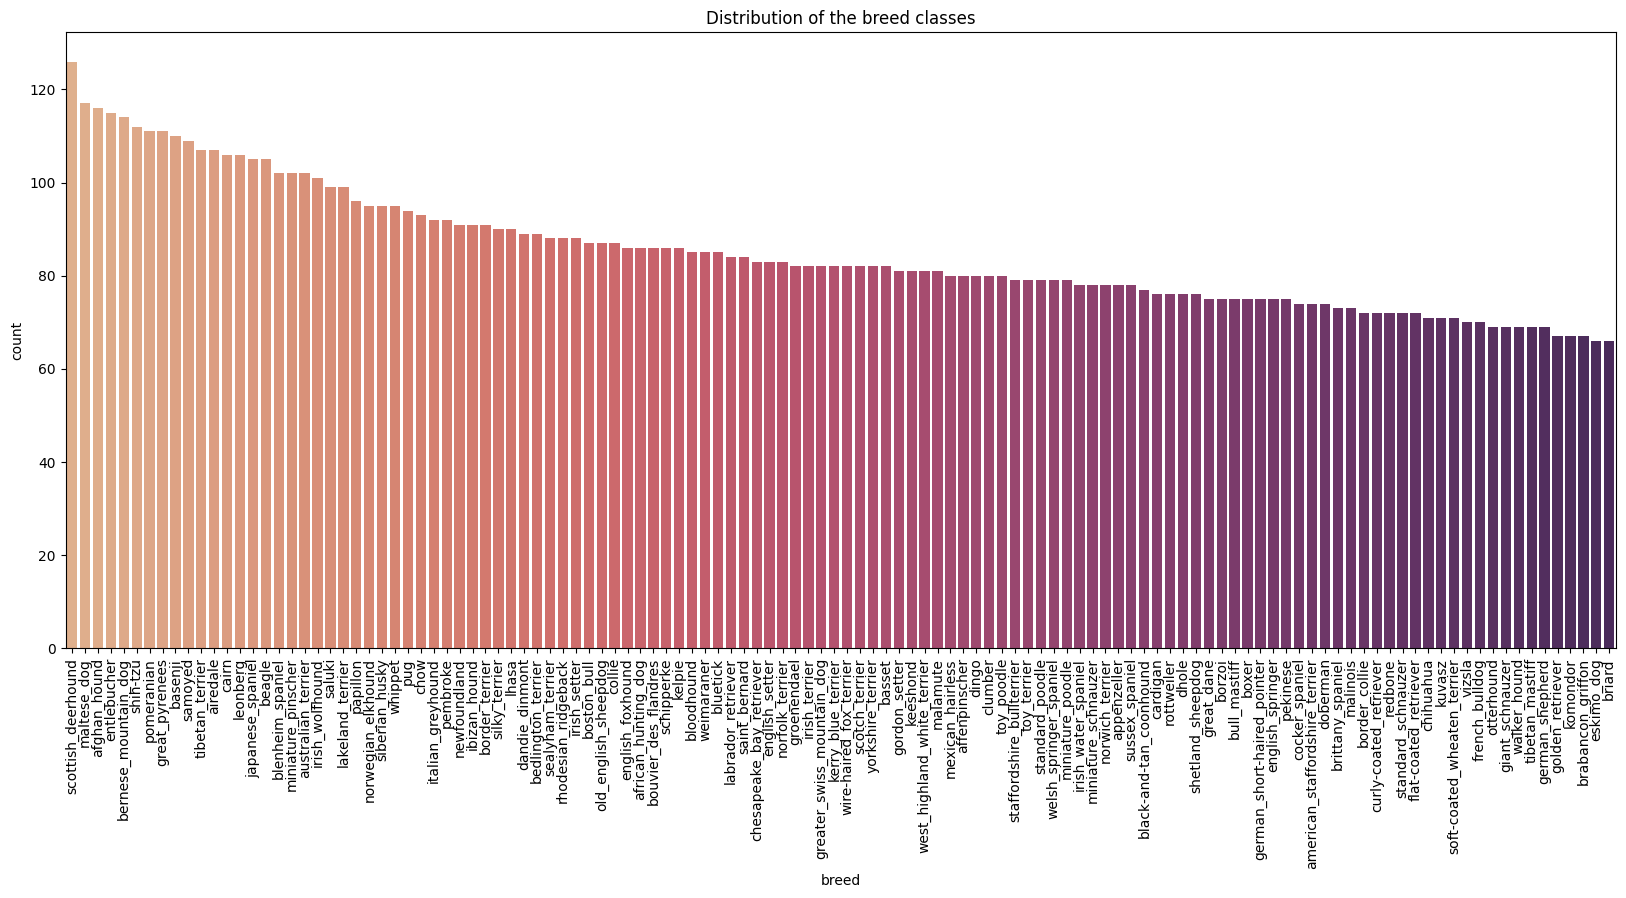

In [5]:
breed_classes = label_df.breed.value_counts().reset_index()
plt.figure(figsize=(20,8))
sns.barplot(breed_classes, x='breed', y='count', palette="flare")
plt.xticks(rotation=90)
plt.title("Distribution of the breed classes")
plt.show()

### Label Encoding

###Encode data

In [6]:
# Encode the 'breed' column to numeric values
le = LabelEncoder()
label_df['encoded_label'] = le.fit_transform(label_df['breed'])

# Add full file paths for image loading
label_df['file_path'] = './train/' + label_df['id'] + '.jpg'

label_df

,id,breed,encoded_label,file_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19,./train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37,./train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,85,./train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15,./train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49,./train/0021f9ceb3235effd7fcde7f7538ed62.jpg
...,...,...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi,18,./train/ffd25009d635cfd16e793503ac5edef0.jpg
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont,35,./train/ffd3f636f7f379c51ba3648a9ff8254f.jpg
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale,3,./train/ffe2ca6c940cddfee68fa3cc6c63213f.jpg
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher,75,./train/ffe5f6d8e2bff356e9482a80a6e29aac.jpg


In [7]:
# Define a function to load and preprocess the image
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    #add additional preprocessing steps here if needed
    return image, label

# Define the file paths and labels
file_paths = label_df['file_path'].values
labels = label_df['encoded_label'].values

#Train_validation_test_split (70/20/10)
#two stage split:
# 1st:(train & validate)/test:0.9/0.1
# 2nd: train & validate:0.77778/0.22222=(0.7/0.9)/(0.2/0.9)
train_validate_files, test_files, train_validate_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.1, random_state=42, stratify = labels)
train_files, validate_files, train_labels, validate_labels = train_test_split(
    train_validate_files, train_validate_labels, test_size=0.2222, random_state=42,
    stratify = train_validate_labels)

# Create TensorFlow datasets for train and test sets
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset = train_dataset.map(load_and_preprocess_image)

validate_dataset = tf.data.Dataset.from_tensor_slices((validate_files, validate_labels))
validate_dataset = validate_dataset.map(load_and_preprocess_image)

test_dataset = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
test_dataset = test_dataset.map(load_and_preprocess_image)



In [8]:
print( test_files.shape, train_files.shape, validate_files.shape)


(1023,) (7154,) (2045,)


In [9]:
element_spec = train_dataset.element_spec

# Print the element_spec
print("Element spec:")
print(element_spec)

#data has various shape

# Example to iterate through the dataset
for image, label in train_dataset.take(10):
    print(image.numpy().shape, label)

Element spec:
(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
(450, 380, 3) tf.Tensor(108, shape=(), dtype=int64)
(500, 333, 3) tf.Tensor(71, shape=(), dtype=int64)
(500, 375, 3) tf.Tensor(29, shape=(), dtype=int64)
(269, 150, 3) tf.Tensor(113, shape=(), dtype=int64)
(411, 300, 3) tf.Tensor(69, shape=(), dtype=int64)
(250, 300, 3) tf.Tensor(81, shape=(), dtype=int64)
(347, 400, 3) tf.Tensor(81, shape=(), dtype=int64)
(499, 500, 3) tf.Tensor(82, shape=(), dtype=int64)
(375, 500, 3) tf.Tensor(14, shape=(), dtype=int64)
(400, 500, 3) tf.Tensor(75, shape=(), dtype=int64)


In [10]:
# check if image properly loaded
# for image, label in train_dataset.take(10):
# for image, label in test_dataset.take(10):
for image, label in validate_dataset.take(10):  # Take the first 10 elements from the dataset
    plt.figure(figsize=(5, 5))
    plt.imshow(image.numpy())
    plt.title(f"Label: {label.numpy()}")
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

##ResNet

### Preprocess data

In [16]:
# Print the element_spec
print("Element spec:")
print(train_dataset.element_spec)

Element spec:
(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [17]:
# #resize as needed
def preprocess_image(image):
    # Resize the image to the desired input size
    image = tf.image.resize(image, (224, 224))

    # # Normalize the pixel values
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.keras.applications.resnet.preprocess_input(image)

    return image

# # Apply the preprocessing function to your dataset
# #this does not change the base dataframe, which reserve image form for other models
train_101_dataset = train_dataset.map(lambda image, label: (preprocess_image(image), label))
test_101_dataset = test_dataset.map(lambda image, label: (preprocess_image(image), label))
validate_101_dataset = validate_dataset.map(lambda image, label: (preprocess_image(image), label))

# # Batch the dataset
batch_size = 128
train_101_dataset = train_101_dataset.shuffle(7500)
train_101_dataset = train_101_dataset.batch(batch_size)
train_101_dataset = train_101_dataset.prefetch(tf.data.AUTOTUNE)

test_101_dataset = test_101_dataset.batch(batch_size)
test_101_dataset = test_101_dataset.prefetch(tf.data.AUTOTUNE)


validate_101_dataset = validate_101_dataset.batch(batch_size)
validate_101_dataset = validate_101_dataset.prefetch(tf.data.AUTOTUNE)

# # # Prefetch the data (optional)
# # dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [18]:
#Use this to check batch size, it accidentally batch before, need to unbatch before rebatch
#if batched: (TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32, name=None)
#if not batched: (TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)

print(train_101_dataset.element_spec)
print(test_101_dataset.element_spec)
print(validate_101_dataset.element_spec)

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


###Build Model

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

res_net_base = tf.keras.applications.ResNet101(weights='imagenet',
                                             include_top=False,
                                             input_shape=(224, 224, 3))

# Freeze the base layers
res_net_base.trainable = False

171446536/171446536 [==============================] - 9s 0us/step


In [20]:
resnet_model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  # resize_and_rescale,
  data_augmentation,
  res_net_base,
  layers.GlobalAveragePooling2D(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(512, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.3),
  layers.Dense(512, activation='relu'),# Reduce the first dense layer units, focus on efficiency
  layers.BatchNormalization(),  # Helps in normalizing activations, also acts as a regularizer
  layers.Dropout(0.3),  # Adjust dropout rate for a good balance between regularization and training speed
  layers.Dense(256, activation='relu'),  # More focused capacity
  layers.Dense(120, activation='softmax')
])

###Compile and fit model

In [24]:
# Compile the model
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('../Keras_model/resnet_model_suffled_128.keras', monitor='val_accuracy', save_best_only=True)

# Fit the model
epochs = 100


resnet_history = resnet_model.fit(train_101_dataset,
                    epochs=epochs,
                    # batch_size=batch_size, ##already define batch size in dataset
                    validation_data=validate_101_dataset,
                    callbacks=[early_stopping, model_checkpoint
                               ])

# Calling `save('my_model.keras')` creates a zip archive `my_model.keras`.

# # It can be used to reconstruct the model identically.

# # Let's check:
# np.testing.assert_allclose(
#     resnet_model.predict(test_101_dataset), reconstructed_model.predict(test_101_dataset)
# )

Epoch 1/100
56/56 [==============================] - 671s 3s/step - loss: 3.7079 - accuracy: 0.1735 - val_loss: 2.3938 - val_accuracy: 0.3707
Epoch 2/100
56/56 [==============================] - 25s 247ms/step - loss: 2.1723 - accuracy: 0.4203 - val_loss: 1.4079 - val_accuracy: 0.5956
Epoch 3/100
56/56 [==============================] - 24s 242ms/step - loss: 1.8300 - accuracy: 0.4867 - val_loss: 1.1848 - val_accuracy: 0.6479
Epoch 4/100
56/56 [==============================] - 24s 241ms/step - loss: 1.6755 - accuracy: 0.5161 - val_loss: 1.0798 - val_accuracy: 0.6768
Epoch 5/100
56/56 [==============================] - 22s 200ms/step - loss: 1.5879 - accuracy: 0.5384 - val_loss: 1.1696 - val_accuracy: 0.6636
Epoch 6/100
56/56 [==============================] - 24s 246ms/step - loss: 1.4886 - accuracy: 0.5703 - val_loss: 1.0689 - val_accuracy: 0.6773
Epoch 7/100
56/56 [==============================] - 22s 199ms/step - loss: 1.3909 - accuracy: 0.5955 - val_loss: 1.2846 - val_accuracy: 0

###Test and Visualization

In [25]:
reconstructed_resnet_model = keras.models.load_model("../Keras_model/resnet_model_suffled_128.keras")
reconstructed_resnet_model.evaluate(test_101_dataset, verbose=2)

8/8 - 69s - loss: 1.1717 - accuracy: 0.7077 - 69s/epoch - 9s/step


[1.1717450618743896, 0.7077223658561707]

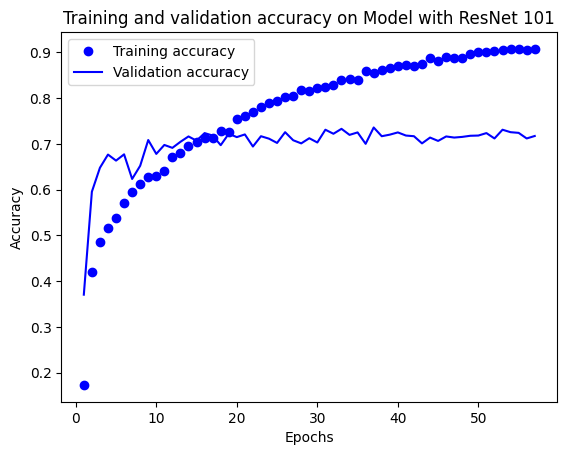

In [62]:
resnet_history_dict = resnet_history.history
accuracy = resnet_history_dict["accuracy"]
val_accuracy = resnet_history_dict["val_accuracy"]
epochs = range(1, len(val_accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy on Model with ResNet 101")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##Inception V3 (version 2)

###Preprocess data to inception V3 standard

In [27]:
# #resize as needed
def preprocess_image(image):
    # Resize the image to the desired input size
    image = tf.image.resize(image, (299, 299))

    # # Normalize the pixel values
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.keras.applications.inception_v3.preprocess_input(image)

    return image

# # Apply the preprocessing function to your dataset
# #this does not change the base dataframe, which reserve image form for other models
train_v3_dataset = train_dataset.map(lambda image, label: (preprocess_image(image), label))
test_v3_dataset = test_dataset.map(lambda image, label: (preprocess_image(image), label))
validate_v3_dataset = validate_dataset.map(lambda image, label: (preprocess_image(image), label))

# # Batch the dataset
batch_size = 128
train_v3_dataset = train_v3_dataset.shuffle(7500)
train_v3_dataset = train_v3_dataset.batch(batch_size)
train_v3_dataset = train_v3_dataset.prefetch(tf.data.AUTOTUNE)

test_v3_dataset = test_v3_dataset.batch(batch_size)
test_v3_dataset = test_v3_dataset.prefetch(tf.data.AUTOTUNE)

validate_v3_dataset = validate_v3_dataset.batch(batch_size)
validate_v3_dataset = validate_v3_dataset.prefetch(tf.data.AUTOTUNE)


###Building model

In [28]:
#Use image augmentation layer, where is image in augmented randomly every epoch
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

inceptionV3_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base layers
inceptionV3_base.trainable = False

inception_model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  # resize_and_rescale,
  data_augmentation,
  inceptionV3_base,
  layers.GlobalAveragePooling2D(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(512, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.3),
  layers.Dense(512, activation='relu'),# Reduce the first dense layer units, focus on efficiency
  layers.BatchNormalization(),  # Helps in normalizing activations, also acts as a regularizer
  layers.Dropout(0.3),  # Adjust dropout rate for a good balance between regularization and training speed
  layers.Dense(256, activation='relu'),  # More focused capacity
  layers.Dense(120, activation='softmax')
])

87910968/87910968 [==============================] - 6s 0us/step


###Compile and fit model

In [29]:
inception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
inception_model_checkpoint = tf.keras.callbacks.ModelCheckpoint('../Keras_model/inception_model_suffled_128.keras', monitor='val_accuracy', save_best_only=True)

# Fit the model
epochs = 100


inception_history = inception_model.fit(train_v3_dataset,
                    epochs=epochs,
                    # batch_size=batch_size, ##already define batch size in dataset
                    validation_data=validate_v3_dataset,
                    callbacks=[early_stopping, inception_model_checkpoint])

Epoch 1/100
56/56 [==============================] - 47s 481ms/step - loss: 3.4590 - accuracy: 0.2295 - val_loss: 2.8760 - val_accuracy: 0.5477
Epoch 2/100
56/56 [==============================] - 21s 192ms/step - loss: 1.9566 - accuracy: 0.4775 - val_loss: 1.3922 - val_accuracy: 0.7037
Epoch 3/100
56/56 [==============================] - 19s 159ms/step - loss: 1.7094 - accuracy: 0.5246 - val_loss: 1.1319 - val_accuracy: 0.6851
Epoch 4/100
56/56 [==============================] - 21s 196ms/step - loss: 1.6220 - accuracy: 0.5544 - val_loss: 0.8485 - val_accuracy: 0.7521
Epoch 5/100
56/56 [==============================] - 19s 162ms/step - loss: 1.5626 - accuracy: 0.5668 - val_loss: 0.8726 - val_accuracy: 0.7257
Epoch 6/100
56/56 [==============================] - 20s 192ms/step - loss: 1.4610 - accuracy: 0.5795 - val_loss: 0.7384 - val_accuracy: 0.7716
Epoch 7/100
56/56 [==============================] - 20s 190ms/step - loss: 1.4018 - accuracy: 0.5903 - val_loss: 0.7063 - val_accuracy:

###Test and visualization

In [30]:
reconstructed_inception_model = keras.models.load_model("../Keras_model/inception_model_suffled_128.keras")
reconstructed_inception_model.evaluate(test_v3_dataset, verbose=2)

8/8 - 8s - loss: 0.5072 - accuracy: 0.8553 - 8s/epoch - 1s/step


[0.5071998238563538, 0.8553274869918823]

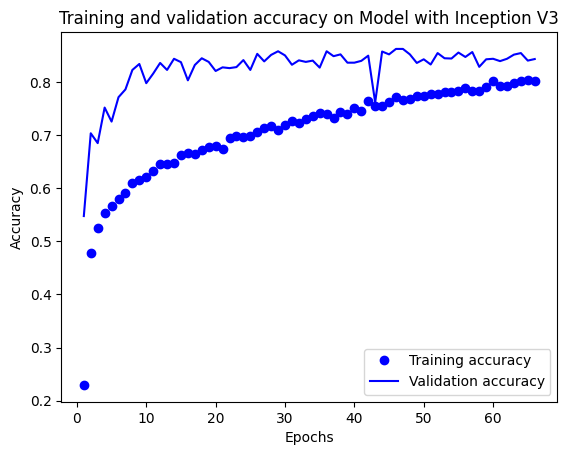

In [61]:
inception_history_dict = inception_history.history
accuracy = inception_history_dict["accuracy"]
val_accuracy = inception_history_dict["val_accuracy"]
epochs = range(1, len(val_accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy on Model with Inception V3")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [58]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                       

In [59]:
inception_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_96 (Ba  (None, 512)               2048      
 tchNormalization)                                    